# Introduction

This notebook takes the historical data you have been provided and constructs three models - AutoEncoder, One Class SVM, PCA-based - as an illustration of how you might want to proceed with your own analysis. If you would like to understand more about any of these models please ask any of the workshop coveners.

## Anomaly Detection

The goal of anomaly detection is to identify example feature sets which look like outliers with respect to the bulk of data. The key assumption is that there are at least two non-overlapping underlying statistical distributions with the exmaples we are interseted in, the anomalies, coming from a rarely sampled distribution with respect to the bulk of the data.

In a real world analysis we would usually not know which data are from which distribution, at least until we start investigating the cause of statistical anomalies in the field through some kind of inspection process. In this workshop you have been provided with inspection results which effectively label the different distributions. That means in principle you can implement a supervised learning approach to get better performance, or at least bias the training data in favour of the distribution you would like to learn in an unsupervised or semi-supervised learning approach. In fact we do the latter in the following workflow by removing the labeled fraud data from the training set.

A genenral lesson is that detection of fraud is a process which will require a feedback loop from inspections in the field to gradually improve model performance. Furthermore as the system you are trying to model is itself intelligent (fraudsters might change their behavior in response to a systematic pattern in inspections, or the inspection results themselve can become corrupt), the system is adversarial. It will therefore be necessary to evolve the modeling strategy in response to changes in the underlying system. You might want to think about the implications for running and managing such a model which is going to indentify future fraud cases.

# 1. Load and Inspect the Data

First we would like to get a feeling for the data and understand which features may be predictive for the target we are training variable we are training for.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read excel requires python package xlrd
raw_data = pd.read_excel('data/Historic_data_WS_EPFL.xlsx')
print(len(raw_data))
raw_data.head()

38412


,Record ID,Certificate Number,Business Name,Inspection Date,Inspection Result,Borough,Building Number,Street,Description,City,...,S20,S21,S22,S23,S24,S25,S26,S27,S28,Vol
0,26459-2017-ENFO,5403790,NYC GOURMET DELI INC.,04/19/2017,Violation Issued,Manhattan,853,9TH AVE,NaN,NEW YORK,...,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00
1,70754-2016-ENFO,5402310,2922 DELI FOOD INC,10/31/2016,Violation Issued,Manhattan,2922,FREDERICK DOUGLASS BLVD,NaN,NEW YORK,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00
2,19411-2016-ENFO,5390237,WESTCHESTER PAWNBROKER INC.,03/21/2016,Violation Issued,Bronx,1617,WESTCHESTER AVE,NaN,BRONX,...,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93
3,11253-2017-ENFO,5406421,"WHOLE FOODS MARKET GROUP, INC.",2017-10-02 00:00:00,Violation Issued,Brooklyn,214,3RD ST,NaN,BROOKLYN,...,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00
4,74088-2017-ENFO,5422856,785 GRAND FOOD CORP.,2017-07-12 00:00:00,Violation Issued,Brooklyn,785,GRAND ST,NaN,BROOKLYN,...,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00


There are 38212 examples and 41 features per example, some categorical and some numeric. The target value we are interested in can be inferred from the column `Inspection Result` so lets look at that column in more detail:

In [3]:
print(raw_data['Inspection Result'].value_counts())

No Violation Issued    25737
Pass                   12277
Violation Issued         344
Warning                   32
Fail                      22
Name: Inspection Result, dtype: int64


It looks like we can further refine these categories into two classes, `normal` and `fraud`, given that e.g., `Pass` and `No Violation Issued` are likely synonymous. Let's add a new variable `class` which assigns this binary label:

In [4]:
# create the column 'class' from the column 'Inspection Result'
raw_data['class'] = ['normal' if ires in ['No Violation Issued','Pass'] else 'fraud' 
                     for ires in raw_data['Inspection Result']]

Let's now look at the balance of our binary labels:

In [5]:
# display fraction of each binary label
print(raw_data['class'].value_counts(normalize=True))

normal    0.989639
fraud     0.010361
Name: class, dtype: float64


It looks like frauds are occuring in about 1% of cases. Given this, and given that we have the luxury of inspection result information to give us this information in the first place, a reasonable approach might be to model the distribution of normal data as well as possible and then use a hypthesis test to see if any new example was indeed drawn from that distribution. Note that we are assuming that inspection results are 100% reliable - no one has been paying off a corrupt inspector to get a favorable report.

Next let's inspect the other features and see which may be useful as input to a model:

In [6]:
print("\n##### HAS NULL VALUES #####\n")
print(raw_data.drop(['class', 'Inspection Result'], axis=1).isnull().any())
print("\n##### DATA TYPES #####\n")
print(raw_data.drop(['class', 'Inspection Result'], axis=1).dtypes)
print("\n##### UNIQUE ENTRIES #####\n")
print(raw_data.nunique())


##### HAS NULL VALUES #####

Record ID             False
Certificate Number    False
Business Name          True
Inspection Date       False
Borough                True
Building Number        True
Street                 True
Description            True
City                   True
State                  True
Zip                    True
S1                    False
S2                    False
S3                    False
S4                    False
S5                    False
S6                    False
S7                    False
S8                    False
S9                    False
S10                   False
S11                   False
S12                   False
S13                   False
S14                   False
S15                   False
S16                   False
S17                   False
S18                   False
S19                   False
S20                   False
S21                   False
S22                   False
S23                   False
S24               

We can see that perhaps the numeric data appears to be more reliable that than categorical data. So a reasonable first iteration of the model building process might just proceed with the numeric features: `Vol`, `S1`, `S2`, ..., `S27`, `S28`. If the model turns out not to be performant we can always investigate adding the categorical data as inputs in a second iteration.

We will now do some basic visualization of the 29 numeric data features to see if there are any indications they might help us identify anomalous feature sets and if they are well suited to being used as input for a multivariate model:

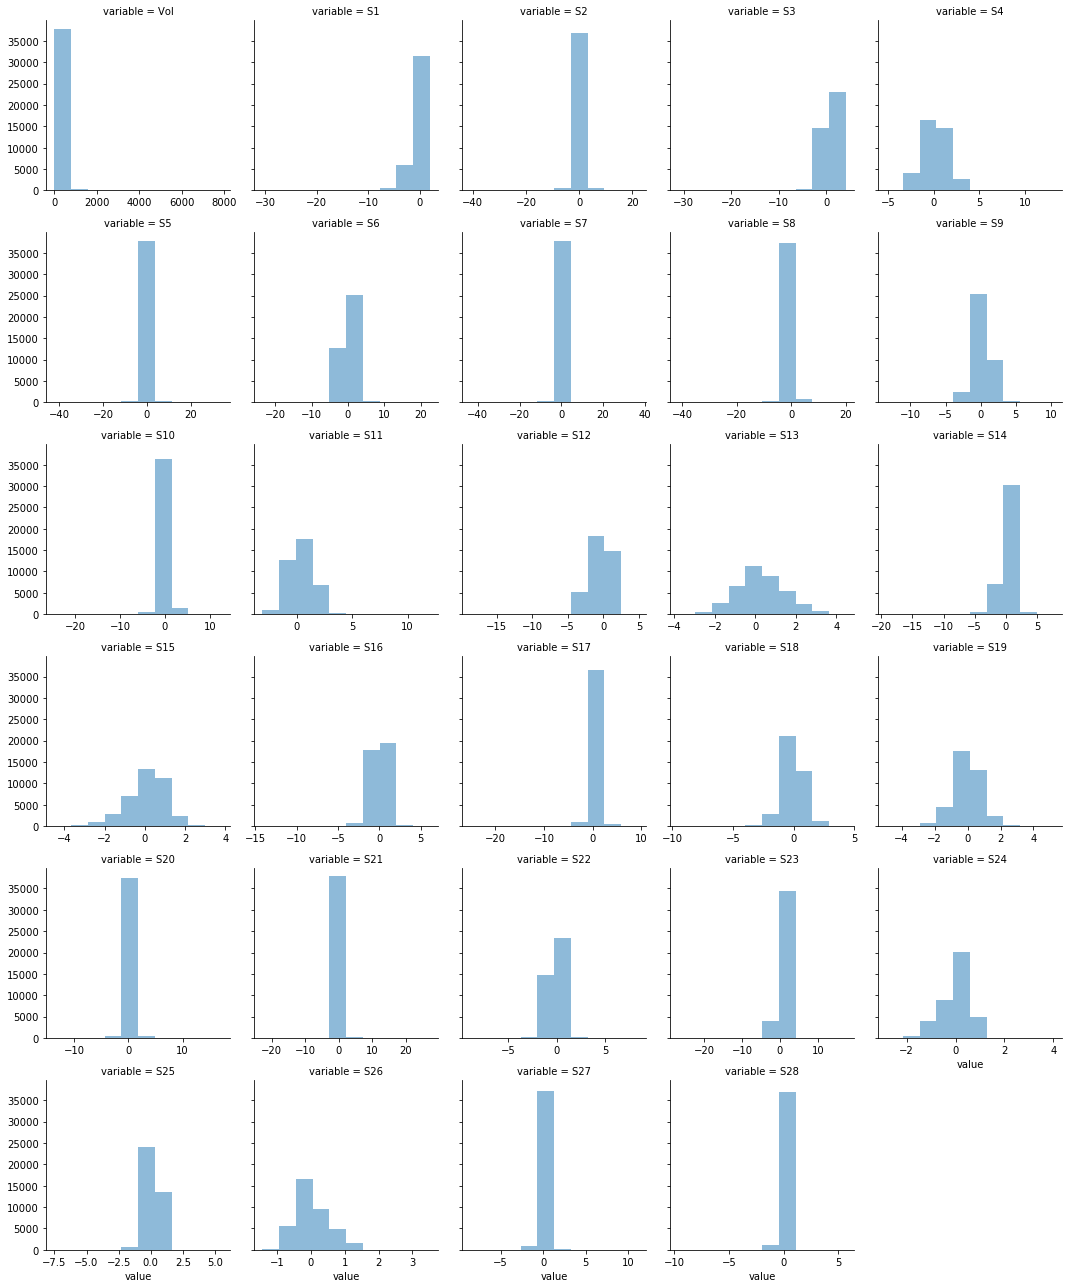

In [7]:
# plot frequency historgrams of the numerical data
numeric_cols = ['Vol'] + ['S{}'.format(i) for i in range(1,29)]

grid = sns.FacetGrid(pd.melt(raw_data[numeric_cols]), col='variable', col_wrap=5, sharex=False)
grid.map(plt.hist, "value", alpha=.5)
pass

We can see that several distributions are skewed, this is encouraging as we might expect anomalies to appear in the tails of skewed distributions. If that is the case then it's a reasonable to expect we can train a model with decent performance. We could go further here and explicitly overlay the `normal` and `fraud` data on the same plots to see if there is indeed separation. In fact below we will use a slightly difference method to do this across all the numeric data dimensions.

Next let's see how correlated the variables are:

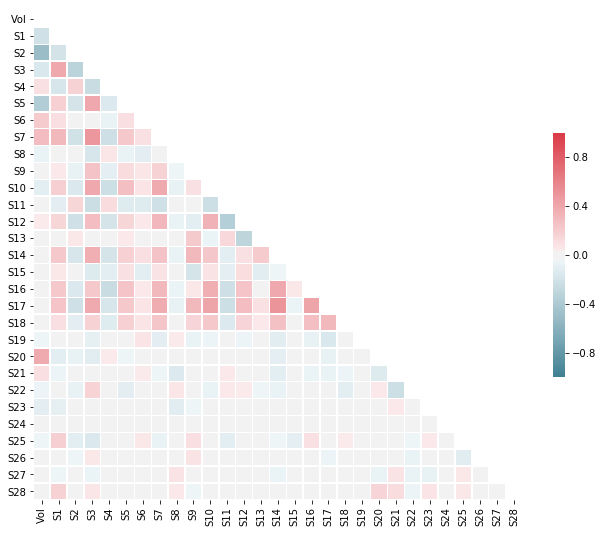

In [8]:
# compute the correlation matrix as a Dataframe
corr_mat = raw_data[numeric_cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, axes = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
pass

We can see that the correlation between variables is generally low, this is incouraging particularly if we were thinking of doing supervised classification with a random forest.

If we were to investigate how the categorical data are distributed across the numeric data TSNE is a potential option. We will not perform TSNE here as it can be very computationally expensive, even for this relatively small dataset. 
We would run it as follows:
```python
from sklearn.manifold import TSNE

# transform the numeric data to 2 components
tsne = TSNE(n_components=2, random_state=11235)
X_tsne = tsne.fit_transform(raw_data[numeric_cols])

# visualize the t-SNE result
data_to_plot = pd.concat(
    [raw_data, pd.DataFrame(X_tsne, columns = ['tsne_x', 'tsne_y'])], 
    axis=1
)

# for each category of interest plot the TSNE result
categories = ['Inspection Result', 'Class', 'State', 'Borough']
for col in cols_overlay: 
    sns.lmplot(
        x='tsne_x', y='tsne_y', 
        data=data_to_plot, fit_reg=False, 
        hue=col, scatter_kws={'alpha':0.3}, size=10, aspect=1
    )
```


# 2. Split and Scale the Data

We now need to assign our train, validation and test samples so that we can make fair assessments when deciding which model or set of hyperparameters performs best. Although the data provided can be ordered in time, each example can be thought of as independent so we can randomly split the data. Note that in a lot of anomaly problems time order is important meaning the data separation method will need to be non-random in that case. Please ask one of the conveners if you don't understand why. As mentioned above we are going to use the luxury of our inspection labels to remove the frauds from the training data, if you would like to try and build the model with those still present, which is more challenging but more representative of what a new anomaly detection project might look like then please do!

In [9]:
from sklearn.model_selection import train_test_split

# fix the random seed for reproducible results
RANDOM_SEED = 1234

# separate the input features and target data into appropriate matrices
X_all = raw_data[numeric_cols].values
y_all = raw_data['class'].values

# first split the train from the test with ratio 2:1 
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=RANDOM_SEED
)

# further split train into train and validation
X_train, X_val, y_train, y_val, = train_test_split(
    X_train_all, y_train_all, test_size=0.25, random_state=RANDOM_SEED+4321
)

print("TRAIN input shape={}; target shape={}; normal={};  fraud={}"
      .format(X_train.shape, y_train.shape, 
              len(y_train[y_train=='normal']), len(y_train[y_train=='fraud']))
     )
print("VAL   input shape= {}; target shape={};  normal={};   fraud={}"
      .format(X_val.shape, y_val.shape, 
              len(y_val[y_val=='normal']), len(y_val[y_val=='fraud']))
     )
print("TEST  input shape= {}; target shape={};  normal={};   fraud={}"
      .format(X_test.shape, y_test.shape, 
              len(y_test[y_test=='normal']), len(y_test[y_test=='fraud']))
     )

TRAIN input shape=(23046, 29); target shape=(23046,); normal=22818;  fraud=228
VAL   input shape= (7683, 29); target shape=(7683,);  normal=7603;   fraud=80
TEST  input shape= (7683, 29); target shape=(7683,);  normal=7593;   fraud=90


We can see from the frequency histograms that some features have significantly larger ranges than others. We might be able to improve the convergence of gradient descent and associated methods if the features are in the same range. If we are planning to use activations such as sigmoid or tanh in our model we might choose to have the range correspond to the dynamic range of those activations. For now we will use the standard scaler but feel free to change this if you want to investigate whether the choice of scaler can improve performance. As the choice of scaler is effectively a tunable hyperparameter we will fit it with the train dataset and then apply it to all datasets.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

We also save the scaler to disk as we will need it to make predictions in a production environment:

In [11]:
from sklearn.externals import joblib

joblib.dump(scaler, 'scaler.model')
pass

# 3. Model Training

We will try three model strategies for our anomaly detection:
* Autoencoder implemented with Keras with tensorflow backend
* One Class SVM implemented with scikit-learn
* PCA deconstruction and inverse implemented with scikit-learn

## Autoencoder

The autoencoder model aims to derive a data driven representation of the identity function. Given that by far the majority of the training data are of class `normal` we might expect this identity mapping to perform well for that class and less well for the class where we have far fewer training examples. It follows that if we calculate the performance of the mapping using, e.g., mean squared error, and determine the 99% quantile of the performance we might start to identify the `fraud` class. Let's see how it performs:

First we construct the model. We will use a shallow autoencoder with no hyperparameter optimization (the setup of the hidden layer is fairly arbitrary and there may be significant room for improvement). As the model will have number of parameters comparable to a significant fraction of the training dataset we feel it's necessary to implement regularization to avoid overfitting; we use simple L1 but it might be interesting to see if dropout can improve performance:

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import keras.backend as K

K.clear_session()

# input layer of 29 numeric features
input_layer = Input(shape=(29, ))

# encoding layer with arbitrary hyperparameters and L1 regularization
encoder = Dense(
    20, activation="relu",
    activity_regularizer=regularizers.l1(10e-5)
)(input_layer)

# decoding layer
decoder = Dense(29, activation='relu')(encoder)

# book the model and summarize 
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 29)                609       
Total params: 1,209
Trainable params: 1,209
Non-trainable params: 0
_________________________________________________________________


Next configure and train the model, we will save the model for later use, note this introduces a hidden dependency to `h5py`:

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard

# require model be saved and logged
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

# compile the model for training
autoencoder.compile(optimizer='adam', loss='mean_squared_error', 
                    metrics=['mae', 'acc'])

n_epochs = 100
batch_size = 64

# train
history = (
    autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=n_epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=1,
        validation_data=[X_val_scaled, X_val_scaled],
        callbacks=[checkpointer, tensorboard]
    ).history
)

Train on 23046 samples, validate on 7683 samples
Epoch 1/100
23046/23046 [==============================] - 0s 21us/step - loss: 1.0006 - mean_absolute_error: 0.6040 - acc: 0.2282 - val_loss: 0.8900 - val_mean_absolute_error: 0.5663 - val_acc: 0.4040

Now we have a trained model let's plot the loss evolution as a function of training input:

In [ ]:
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss','loss'])
pass

We can see that there is not too much divergence between the validation and training datasets, and that the curve has started to flatten at higher epochs with respect to the initial twenty. Now we want to use the test data to determine the 99% threshold which assigns an anomaly and see how that impact the performance of anomaly detection on the validation data:

In [ ]:
from keras.models import load_model
from sklearn.metrics import mean_squared_error

K.clear_session()

trained_model = load_model('model.h5')

train_predicted = trained_model.predict(X_train_scaled)

train_mse = mean_squared_error(train_predicted.T, X_train_scaled.T, multioutput='raw_values')

thresh_train = np.percentile(train_mse, 99)
print(thresh_train)

We will first visualize the mse plots for both target classes, and then for the validation data plot the confusion matrix and show precision and recall:

In [ ]:
from sklearn.metrics import precision_score, recall_score
from amld_functions import plot_confmat

# propagate the scaled validation data through prediction workflow
val_predicted = trained_model.predict(X_val_scaled)
val_mse = mean_squared_error(val_predicted.T, X_val_scaled.T, multioutput='raw_values')
val_model_status = ['normal' if imse < thresh_train else 'fraud' for imse in val_mse]

# plot the mse residuals
pred_res = pd.DataFrame(dict(mse=val_mse, label=y_val))
pred_res['index'] = pred_res.index
pred_res.groupby('label')['mse'].apply(np.mean)
fig = sns.lmplot(data=pred_res, x='index', y='mse',
                 hue='label', fit_reg=False, size=5, aspect=2.5)

# plot the confusion matrix
plot_confmat(y_val, val_model_status)

pr = precision_score(y_val, val_model_status, pos_label='fraud')
rc = recall_score(y_val, val_model_status, pos_label='fraud')
print("Precision: {:0.2f}; Recall: {:0.2f}".format(pr, rc))

We have moderate performance, how might this change if we take advantage of the inspection labels and only train the autoencoder using data from the `normal` class?

We will not go through the next examples in as much detail, just present the trainind code and validation performance.

## One Class SVM

Again keep in mind that there has been no hyperparameter optimization in the following.

In [ ]:
from sklearn.svm import OneClassSVM

# fit the model
mod_svm = OneClassSVM(nu=0.1, kernel='rbf', gamma=0.01)
mod_svm.fit(X_train_scaled)

# predict
val_model_status = ['normal' if ival ==1 else 'fraud' for ival in mod_svm.predict(X_val_scaled)]

#save the model
joblib.dump(mod_svm, 'svm.model')

# plot the confusion matrix
plot_confmat(y_val, val_model_status)

pr = precision_score(y_val, val_model_status, pos_label='fraud')
rc = recall_score(y_val, val_model_status, pos_label='fraud')
print("Precision: {:0.2f}; Recall: {:0.2f}".format(pr, rc))

## PCA-Based Anomaly

This uses the same workflow as the autoencoder, we will optimize the downsample step by determine how many components in PCA explain 95% of the variance:

In [ ]:
from sklearn import decomposition

# find number of components retaining 95% variance
pca = decomposition.PCA()
pca.fit(X_train_scaled)

# plot the variance as a function of components
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Cumulative explained variance')

# determine the number of components to use
cum_var = pca.explained_variance_ratio_.cumsum()
num_comp = cum_var[cum_var <= 0.95].argmax()
print('Number of components to be used = {}'.format(num_comp))

# perform PCA decomposition on the train set
pca = decomposition.PCA(n_components=num_comp)
pca.fit(X_train_scaled)

# save the model
joblib.dump(pca, 'pca.model')

pass

In [ ]:
# calculate the threshold from the training data

X_train_pca = pca.transform(X_train_scaled)
X_train_projected = pca.inverse_transform(X_train_pca)

X_train_mse = mean_squared_error(X_train_scaled.T, X_train_projected.T, multioutput='raw_values')

thres_pca = np.percentile(X_train_mse, 99)

print(thres_pca)

In [ ]:
# propagate the scaled validation data through prediction workflow
val_pca = pca.transform(X_val_scaled)
val_projected = pca.inverse_transform(val_pca)
val_mse = mean_squared_error(val_projected.T, X_val_scaled.T, multioutput='raw_values')
val_model_status = ['normal' if imse < thres_pca else 'fraud' for imse in val_mse]

# plot the mse residuals
pred_res = pd.DataFrame(dict(mse=val_mse, label=y_val))
pred_res['index'] = pred_res.index
pred_res.groupby('label')['mse'].apply(np.mean)
fig = sns.lmplot(data=pred_res, x='index', y='mse',
                 hue='label', fit_reg=False, size=5, aspect=2.5)

# plot the confusion matrix
plot_confmat(y_val, val_model_status)

pr = precision_score(y_val, val_model_status, pos_label='fraud')
rc = recall_score(y_val, val_model_status, pos_label='fraud')
print("Precision: {:0.2f}; Recall: {:0.2f}".format(pr, rc))

This model is not particularly performant. However, look what happens when we train omitting the fraud examples in the training set:

In [ ]:
# retrain
pca_updated = decomposition.PCA(n_components=num_comp)
pca_updated.fit(X_train_scaled[np.where(y_train=='normal')])

X_train_pca = pca_updated.transform(X_train_scaled)
X_train_projected = pca_updated.inverse_transform(X_train_pca)

X_train_mse = mean_squared_error(X_train_scaled.T, X_train_projected.T, multioutput='raw_values')

thres_pca = np.percentile(X_train_mse, 99)

joblib.dump(pca_updated, 'pca_updated.model')

# propagate the scaled validation data through prediction workflow
val_pca = pca_updated.transform(X_val_scaled)
val_projected = pca_updated.inverse_transform(val_pca)
val_mse = mean_squared_error(val_projected.T, X_val_scaled.T, multioutput='raw_values')
val_model_status = ['normal' if imse < thres_pca else 'fraud' for imse in val_mse]

# plot the mse residuals
pred_res = pd.DataFrame(dict(mse=val_mse, label=y_val))
pred_res['index'] = pred_res.index
pred_res.groupby('label')['mse'].apply(np.mean)
fig = sns.lmplot(data=pred_res, x='index', y='mse',
                 hue='label', fit_reg=False, size=5, aspect=2.5)

# plot the confusion matrix
plot_confmat(y_val, val_model_status)

pr = precision_score(y_val, val_model_status, pos_label='fraud')
rc = recall_score(y_val, val_model_status, pos_label='fraud')
print("Precision: {:0.2f}; Recall: {:0.2f}".format(pr, rc))

A significant improvement! This final lesson emphasizes how important it can be to work on the data science process iteratively, using feedback from running a non-perfect model in production so that feedback from the field can further improve the model performance.